# Introduction
This notebook is for building and testing a pipeline for creating synthetic data with GANs

## Imports
Import libraries and write settings here.

In [284]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score
import xgboost as xgb
import cufflinks as cf
import seaborn as sns
import matplotlib.pyplot as plt
from kaggle.api.kaggle_api_extended import KaggleApi
from ydata_synthetic.preprocessing.regular.credit_fraud import *
from ydata_synthetic.synthesizers.regular import WGAN_GP, VanilllaGAN
import sklearn.cluster as cluster
from sklearn.preprocessing import PowerTransformer
import pickle
import importlib
import math
import zipfile
import sys
import os
from pathlib import Path
from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell
import pandas as pd
import numpy as np
import psutil
print(list(psutil.virtual_memory())[0:2])
root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

# kaggle imports
api = KaggleApi()
api.authenticate()

# Options for pandas
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)
pd.options.display.max_rows = None

# Visualizations
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

[34359738368, 13680652288]


### Set data paths

In [74]:
external_data = '../data/external/'
raw_data = '../data/raw/'
interim_data = '../data/interim/'
processed_data = '../data/processed/'

### Import data from Kaggle

In [3]:
# downloading from https://www.kaggle.com/mlg-ulb/creditcardfraud
# we write to the raw data directory path with './'
api.dataset_download_files('mlg-ulb/creditcardfraud',
                          path=external_data)

In [97]:
#unzip

with zipfile.ZipFile(external_data+'hospital-readmissions.zip', 'r') as zipref:
    zipref.extractall(raw_data)

#### Create kaggle import data function

In [37]:
# Put data collection code into a .py document in the src/d00_utils folder. From there 
# it can be imported into different jupyter notebooks for easy data 
def kaggle_download_raw(url, in_path):
    api.dataset_download_files(url,
                          path=in_path)
    
def unzip(in_path, out_path):
    pathlist = Path(in_path).rglob('*.zip')
    for path in pathlist:   # get the list of files
        with zipfile.ZipFile(path) as zipref: # treat the file as a zip
            zipref.extractall(out_path)  # extract it in the raw data directory

            
def read_files(in_path, index = False):
    pathlist = Path(in_path).rglob('*.csv')
    dataframes = [pd.read_csv(path, index_col=index) for path in pathlist]
    return dataframes

In [5]:
urls = ['mlg-ulb/creditcardfraud','dansbecker/hospital-readmissions']
#file_names = ['creditcardfraud.zip','hospital-readmissions.zip']

[kaggle_download_raw(url,external_data) for url in urls ]

[None, None]

In [8]:
unzip(external_data, raw_data)

### Read in as pandas dataframes

In [78]:
credit_fraud = read_files(raw_data)[0]
print(credit_fraud.shape)
credit_fraud.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [111]:
readmissions = read_files(raw_data)[1]
readmissions.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Caucasian,race_AfricanAmerican,gender_Female,age_[70-80),age_[60-70),age_[50-60),age_[80-90),age_[40-50),payer_code_?,payer_code_MC,payer_code_HM,payer_code_SP,payer_code_BC,medical_specialty_?,medical_specialty_InternalMedicine,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,...,repaglinide_No,nateglinide_No,chlorpropamide_No,glimepiride_No,acetohexamide_No,glipizide_No,glyburide_No,tolbutamide_No,pioglitazone_No,rosiglitazone_No,acarbose_No,miglitol_No,troglitazone_No,tolazamide_No,examide_No,citoglipton_No,insulin_No,glyburide-metformin_No,glipizide-metformin_No,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-pioglitazone_No,change_No,diabetesMed_Yes,readmitted
0,14,41,0,11,0,0,0,6,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,...,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0
1,2,30,0,12,0,0,1,9,True,False,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,...,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,1
2,5,66,0,22,1,0,2,9,True,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1
3,3,63,0,8,0,0,0,8,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,...,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1
4,5,40,0,6,0,0,1,9,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,0


# Data EDA & Preprocessing

## Credit data

In [264]:
data = credit_fraud.copy()
data_cols = list(data.columns[ data.columns != 'Class'])
label_cols = ['Class']

print('Dataset columns: {}'.format(data_cols))
print('# of data columns: ',len(data_cols))
data.head()

Dataset columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
# of data columns:  30


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [265]:
# 284315 normal transactions (class 0)
# 492 fraud transactions (class 1)

data.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

In [266]:
# Total nulls in dataset (sum over rows, then over columns)

data.isnull().sum().sum()

0

In [267]:
# Duplicates? Yes

normal_duplicates = sum( data.loc[ data.Class==0 ].duplicated() )
fraud_duplicates = sum( data.loc[ data.Class==1 ].duplicated() )
total_duplicates = normal_duplicates + fraud_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Fraud duplicates', fraud_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(data) )

Normal duplicates 1062
Fraud duplicates 19
Total duplicates 1081
Fraction duplicated 0.00379555277784605


Last time value: 48.00


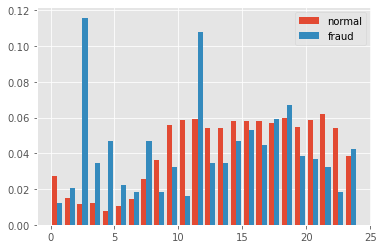

In [268]:
# 'Time' is seconds from first transaction in set
# 48 hours worth of data
# Let's convert time to time of day, in hours

print( 'Last time value: {:.2f}'.format( data['Time'].max() / 3600 ) )

data['Time'] = ( data['Time'].values / 3600 ) % 24

_ = plt.hist( [ data.loc[ data['Class']==0, 'Time'], data.loc[ data['Class']==1, 'Time'] ],
         density=True, label=['normal','fraud'], bins=np.linspace(0,24,25))
plt.legend()
plt.show()

# Looks like normal transactions have a bias towards 8am to midnight
# Fraud has spikes at 2-3am and noon

In [166]:
# several columns heavily skewed, 'Amount' the highest (besides Class)

data.skew()

Time      -0.499981
V1        -3.280667
V2        -4.624866
V3        -2.240155
V4         0.676292
            ...    
V26        0.576693
V27       -1.170209
V28       11.192091
Amount    16.977724
Class     23.997579
Length: 31, dtype: float64

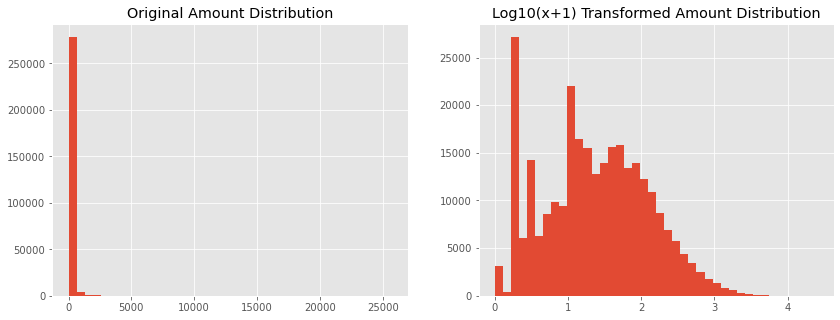

In [269]:
#Example of skewed feature

_ = plt.figure(figsize=(14,5))
_ = plt.subplot(1,2,1);
_ = plt.hist(data['Amount'], bins=40)
_ = plt.title('Original Amount Distribution')

_ = plt.subplot(1,2,2)
d0 = np.log10( data['Amount'].values + 1 )
# d0 = np.log1p( data['Amount'].values ) / np.log(10)
_ = plt.hist( d0, bins=40 )
_ = plt.title('Log10(x+1) Transformed Amount Distribution')
plt.show()

In [270]:
# Use log transformed data

data['Amount'] = d0

In [271]:
# Center and scale all data, only using the middle 99.8%, so outliers don't pull too much.
# First generate the percentile data for each feature

percentiles =  pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.9 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )

percentile_means = \
    [ [ np.mean( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

percentiles


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
min,0.025833,-16.044343,-15.126221,-9.870326,-4.163262,-9.408512,-5.290163,-9.365179,-13.102174,-3.305247,-5.209875,-2.739511,-5.702560,-3.103261,-7.342516,-3.185304,-4.028148,-5.702709,-3.351918,-2.981355,-6.621889,-5.490204,-3.119845,-5.452756,-2.001248,-2.403083,-1.276676,-3.823857,-2.629030,0.000000
max,23.965278,2.344685,7.852129,3.387393,6.235906,8.074611,6.164944,7.972745,6.135087,5.960836,9.134652,3.841478,2.739501,3.237774,3.865350,2.634778,2.709683,4.054770,2.674716,3.390209,5.809376,7.879007,2.260348,4.759942,1.246819,1.873743,2.251097,2.607462,2.095818,3.477266
mean,14.543063,0.020195,0.012756,0.011923,-0.003827,0.002532,-0.000677,0.001153,0.011022,-0.002363,-0.001320,-0.003055,0.006787,-0.000105,0.005590,0.000326,0.003794,0.007291,0.001926,-0.000329,0.002214,-0.002930,0.001083,0.002081,0.000089,0.000504,-0.001117,0.001314,-0.000914,1.375513
stdev,5.827070,1.814661,1.429787,1.419404,1.383725,1.208541,1.263637,1.018486,0.956445,1.064801,0.981458,0.996518,0.935579,0.984448,0.882351,0.904186,0.833654,0.720282,0.817122,0.798721,0.595668,0.550113,0.704365,0.433626,0.596816,0.505554,0.474011,0.330955,0.223416,0.710045


In [272]:
# Center and scale the data using the percentile data we just generated

data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]

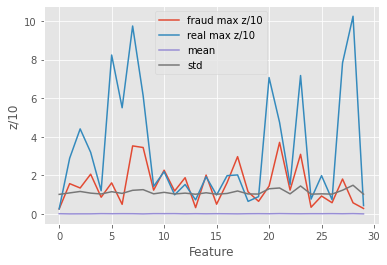

In [273]:
# There are outliers, 50-100 stdevs away from mean in several columns

plot_cols = data_cols
# plt.plot( np.log10( data[ plot_cols ].abs().max().values ) )
# plt.plot( data[ plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='max z/10' )
plt.plot( data.loc[ data.Class==1, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='fraud max z/10' )
plt.plot( data.loc[ data.Class==0, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='real max z/10' )
plt.plot( data[ plot_cols ].mean().values, label='mean' )
# plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
plt.plot( data[ plot_cols ].std().values, label='std' )
plt.xlabel('Feature')
plt.ylabel('z/10')
plt.legend() ; 

In [274]:
#Transform data to Gaussian

data[data_cols] = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(data[data_cols])

data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-2.097892,-0.918361,-0.126941,2.179072,0.985929,-0.256348,0.453311,0.193567,0.019899,0.380248,0.127280,-0.513029,-0.773716,-0.997406,-0.404862,1.711526,-0.600737,0.215343,0.010324,0.503249,0.324326,-0.004980,0.366815,-0.190321,0.008864,0.209150,-0.320634,0.319677,-0.051441,1.116232,0
1,-2.097892,0.627278,0.097411,-0.030922,0.387996,0.031793,0.038355,-0.063818,0.006326,-0.184730,-0.114989,1.523893,1.297063,0.498809,-0.233321,0.674971,0.491301,-0.174764,-0.238217,-0.169665,-0.092147,-0.297283,-0.883694,0.152007,-0.639250,0.286009,0.356852,-0.041941,0.058518,-1.128782,0
2,-2.097861,-0.917772,-0.876575,1.379633,0.341674,-0.374776,1.327090,0.639733,0.171795,-1.453454,0.234507,0.640717,-0.106076,0.724944,-0.256407,2.871130,-2.809860,1.379931,-0.164889,-2.836166,0.681052,0.359178,1.069681,1.507168,-1.129176,-0.653908,-0.205645,-0.157419,-0.171327,1.629849,0
3,-2.097861,-0.751287,-0.198599,1.399416,-0.580509,-0.019312,0.984311,0.191959,0.308552,-1.319307,-0.008705,-0.179208,0.025795,0.517338,-0.381402,-0.720131,-1.192490,-0.825670,2.432502,-1.528564,-0.272131,-0.130886,-0.013017,-0.317606,-1.748833,1.279747,-0.397429,0.138793,0.200887,1.008889,0
4,-2.097829,-0.834752,0.531035,1.158863,0.357472,-0.305871,0.179725,0.479228,-0.331302,0.769637,0.718426,-0.798731,0.495542,1.343519,-1.166584,0.137789,-0.580778,-0.317908,-0.066081,0.986295,0.529106,0.007357,1.107968,-0.233433,0.140403,-0.431047,1.048430,0.541582,0.661431,0.688624,0


#### create data transformation function

- need to work on this

In [ ]:
# def transformations(data):
#     #Log transformation to Amount variable
#     data_cols = list(data.columns[data.columns != 'Class'])
  
#     #data[data_cols] = StandardScaler().fit_transform(data[data_cols])
#     data[data_cols] = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(data[data_cols])
    
#     return data

#### Data distributions by feature and class

(array([[0.23132842, 0.10036743, 0.1150472 , 0.06825705, 0.07139353,
         0.09995609, 0.17574584, 0.24965884, 0.38172531, 0.40134118,
         0.39522247, 0.37002777, 0.32699112, 0.32958772, 0.33292987,
         0.31814727, 0.29871137, 0.2999711 , 0.28194918, 0.27878699,
         0.2872195 , 0.25066149, 0.26189626, 0.26523842, 0.2747507 ,
         0.27999531, 0.21747134, 0.17847098, 0.15201655],
        [0.10400013, 0.80228672, 0.32685755, 0.35657188, 0.20800026,
         0.14857162, 0.28228607, 0.1931431 , 0.14857162, 0.1931431 ,
         0.63885795, 0.32685755, 0.22285742, 0.23771458, 0.25257175,
         0.25257175, 0.28228607, 0.25257175, 0.26742891, 0.29714323,
         0.31200039, 0.25257175, 0.07428581, 0.1931431 , 0.20800026,
         0.07428581, 0.05942865, 0.16342878, 0.16342878]]),
 array([-2.09495911, -1.95787641, -1.8207937 , -1.683711  , -1.54662829,
        -1.40954559, -1.27246289, -1.13538018, -0.99829748, -0.86121477,
        -0.72413207, -0.58704937, -0.44996666,

Text(0.5, 0, 'Time')

(0.0, 0.8)

Text(0, 0.5, 'Fraction')

(array([[0.00134309, 0.00200543, 0.00283337, 0.00472841, 0.00618189,
         0.00932803, 0.01164624, 0.01872965, 0.02369724, 0.03392679,
         0.04901354, 0.07260039, 0.11515606, 0.18037866, 0.29570031,
         0.48614294, 0.63237403, 0.51981215, 0.28162548, 0.09497293,
         0.06255482, 0.12350897, 0.44998993, 0.5385602 , 0.12599277,
         0.10168838, 0.35724321, 0.52080567, 0.09870782],
        [0.11602774, 0.13923329, 0.09282219, 0.12763052, 0.05801387,
         0.08121942, 0.15083606, 0.17404161, 0.26686381, 0.26686381,
         0.26686381, 0.25526103, 0.3132749 , 0.41769987, 0.39449432,
         0.39449432, 0.18564439, 0.19724716, 0.17404161, 0.26686381,
         0.10442497, 0.15083606, 0.26686381, 0.18564439, 0.01160277,
         0.01160277, 0.11602774, 0.03480832, 0.        ]]),
 array([-3.79076904, -3.59924396, -3.40771888, -3.2161938 , -3.02466873,
        -2.83314365, -2.64161857, -2.45009349, -2.25856842, -2.06704334,
        -1.87551826, -1.68399318, -1.49246811,

Text(0.5, 0, 'V1')

(0.0, 0.8)

(array([[4.82925383e-04, 5.35745347e-04, 9.50759348e-04, 1.09412782e-03,
         1.59969033e-03, 2.19580135e-03, 3.07864932e-03, 5.71964751e-03,
         8.98693955e-03, 1.60723604e-02, 3.03111135e-02, 9.07446978e-02,
         2.89196847e-01, 5.71655377e-01, 5.12074458e-01, 3.92927711e-01,
         1.22813962e-01, 4.04450008e-02, 1.82907989e-02, 1.00659760e-02,
         6.75340966e-03, 4.51987976e-03, 3.28238346e-03, 2.32407841e-03,
         1.70533026e-03, 1.23749629e-03, 1.01867073e-03, 8.22482293e-04,
         6.18748147e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 4.98029085e-03, 1.99211634e-02, 0.00000000e+00,
         9.96058170e-03, 1.99211634e-02, 2.98817451e-02, 2.49014543e-02,
         5.97634902e-02, 9.96058170e-02, 1.44428435e-01, 2.58975124e-01,
         2.68935706e-01, 1.84270762e-01, 2.19132797e-01, 2.09172216e-01,
         1.14546690e-01, 1.14546690e-01, 5.97634902e-02, 6.47437811e-02,
         4.48226177e-02, 

Text(0.5, 0, 'V2')

(0.0, 0.8)

(array([[0.00090934, 0.00106323, 0.00151091, 0.0023503 , 0.00299384,
         0.00535813, 0.0073307 , 0.0137101 , 0.02939277, 0.06169544,
         0.12232764, 0.23571574, 0.29434739, 0.31466072, 0.36060353,
         0.36989282, 0.41425478, 0.37024257, 0.32158572, 0.29420749,
         0.24072412, 0.18149091, 0.11654982, 0.08228856, 0.05611347,
         0.03426125, 0.02010348, 0.01053439, 0.00485449],
        [0.12377372, 0.1340882 , 0.17534611, 0.16503163, 0.31974879,
         0.43320804, 0.34037774, 0.34037774, 0.25786193, 0.21660402,
         0.23723297, 0.21660402, 0.23723297, 0.18566059, 0.15471716,
         0.11345925, 0.07220134, 0.05157239, 0.06188686, 0.08251582,
         0.01031448, 0.        , 0.02062895, 0.02062895, 0.        ,
         0.        , 0.        , 0.        , 0.        ]]),
 array([-4.15104756, -3.8992265 , -3.64740543, -3.39558437, -3.1437633 ,
        -2.89194224, -2.64012117, -2.38830011, -2.13647904, -1.88465797,
        -1.63283691, -1.38101584, -1.12919478,

Text(0.5, 0, 'V3')

(0.0, 0.8)

(array([[0.00359478, 0.0057488 , 0.00989991, 0.01686123, 0.02557715,
         0.04218161, 0.06463473, 0.07193841, 0.10936978, 0.17952506,
         0.20631474, 0.25880995, 0.44085992, 0.36076193, 0.40117468,
         0.5242246 , 0.41344258, 0.33869397, 0.2424052 , 0.07410669,
         0.04999884, 0.06824377, 0.03579089, 0.0400276 , 0.0326098 ,
         0.02175413, 0.00786002, 0.00168327, 0.00138371],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.02237281, 0.        , 0.03355921, 0.05593201, 0.07830482,
         0.15660964, 0.11186403, 0.20135525, 0.17898244, 0.27966007,
         0.34677848, 0.34677848, 0.35796488, 0.29084647, 0.36915129,
         0.26847366, 0.22372805, 0.38033769, 0.34677848]]),
 array([-3.54454264, -3.29759722, -3.05065179, -2.80370637, -2.55676094,
        -2.30981552, -2.06287009, -1.81592467, -1.56897925, -1.32203382,
        -1.0750884 , -0.82814297, -0.58119755,

Text(0.5, 0, 'V4')

(0.0, 0.8)

Text(0, 0.5, 'Fraction')

(array([[2.26335792e-04, 4.68838427e-04, 4.93088690e-04, 6.22423429e-04,
         9.37676854e-04, 1.22059659e-03, 2.07743924e-03, 2.91811504e-03,
         4.51863242e-03, 7.40441378e-03, 1.67569321e-02, 6.36731084e-02,
         1.97073808e-01, 4.04567145e-01, 5.73470230e-01, 4.85684277e-01,
         2.64877544e-01, 1.22948836e-01, 6.56050461e-02, 4.21146242e-02,
         1.98124652e-02, 7.90558589e-03, 3.32228609e-03, 1.79451950e-03,
         1.32568107e-03, 8.89176327e-04, 5.33505796e-04, 6.14340008e-04,
         3.63753952e-04],
        [1.09509328e-02, 3.28527984e-02, 4.92791977e-02, 3.83282649e-02,
         0.00000000e+00, 4.38037313e-02, 7.11810633e-02, 9.85583953e-02,
         8.21319961e-02, 1.14984795e-01, 1.25935727e-01, 1.91641324e-01,
         2.51871455e-01, 2.46395988e-01, 2.35445056e-01, 2.08067724e-01,
         2.02592257e-01, 1.31411194e-01, 3.28527984e-02, 2.73773320e-02,
         2.73773320e-02, 3.28527984e-02, 2.19018656e-02, 1.09509328e-02,
         0.00000000e+00, 

Text(0.5, 0, 'V5')

(0.0, 0.8)

(array([[4.15376915e-04, 5.68410515e-04, 5.90272458e-04, 6.01203430e-04,
         7.87029944e-04, 9.07270630e-04, 1.28985463e-03, 1.55219795e-03,
         2.41574469e-03, 3.21370561e-03, 4.80962744e-03, 9.76135750e-03,
         2.54582325e-02, 6.33340486e-02, 1.82612809e-01, 3.72407266e-01,
         5.64573744e-01, 5.57162546e-01, 4.65954520e-01, 2.99377446e-01,
         1.80000307e-01, 9.76245060e-02, 4.94954387e-02, 3.53070378e-02,
         8.78631485e-02, 6.22628134e-02, 2.23538366e-02, 6.40554927e-03,
         2.55784732e-03],
        [1.91067545e-02, 3.18445908e-02, 3.18445908e-02, 7.64270180e-02,
         5.73202635e-02, 3.18445908e-02, 4.45824272e-02, 9.55337725e-02,
         1.08271609e-01, 1.71960791e-01, 1.27378363e-01, 1.97436463e-01,
         2.54756727e-01, 2.35649972e-01, 2.86601318e-01, 2.35649972e-01,
         2.73863481e-01, 2.54756727e-01, 1.97436463e-01, 1.21009445e-01,
         8.91648544e-02, 4.45824272e-02, 2.54756727e-02, 1.91067545e-02,
         6.36891817e-03, 

Text(0.5, 0, 'V6')

(0.0, 0.8)

(array([[2.62447035e-04, 3.28058793e-04, 4.51992115e-04, 6.85278368e-04,
         8.67533253e-04, 8.82113644e-04, 1.47990967e-03, 2.19434882e-03,
         2.65363113e-03, 4.27205451e-03, 6.36434059e-03, 1.28671949e-02,
         4.35297568e-02, 1.64481389e-01, 4.03869535e-01, 5.87684522e-01,
         4.96105087e-01, 2.37580178e-01, 6.47150646e-02, 1.75985317e-02,
         8.04837573e-03, 4.48347017e-03, 2.73382328e-03, 1.75693709e-03,
         1.21746263e-03, 7.72760713e-04, 6.26956805e-04, 3.93670552e-04,
         4.44701920e-04],
        [3.24180333e-02, 3.24180333e-02, 4.32240444e-02, 2.70150278e-02,
         5.40300555e-02, 4.86270500e-02, 7.02390722e-02, 8.10450833e-02,
         1.24269128e-01, 1.35075139e-01, 1.83702189e-01, 1.89105194e-01,
         2.21523228e-01, 1.45881150e-01, 1.51284155e-01, 1.35075139e-01,
         1.83702189e-01, 9.72540999e-02, 6.48360666e-02, 5.40300555e-03,
         1.62090167e-02, 5.40300555e-03, 1.08060111e-02, 0.00000000e+00,
         5.40300555e-03, 

Text(0.5, 0, 'V7')

(0.0, 0.8)

(array([[5.66704013e-04, 6.47661729e-04, 1.00263018e-03, 9.96402660e-04,
         1.88693754e-03, 1.89939257e-03, 2.92693281e-03, 4.60836230e-03,
         4.72045760e-03, 1.27352715e-02, 1.80971633e-02, 2.52961725e-02,
         2.11685745e-01, 9.77203226e-01, 3.32555615e-01, 1.15707259e-01,
         3.00851328e-02, 1.01695346e-02, 4.70800257e-03, 2.70274221e-03,
         1.93053015e-03, 1.45101137e-03, 9.90175143e-04, 7.22391928e-04,
         6.72571795e-04, 4.73291263e-04, 3.92333547e-04, 2.92693281e-04,
         2.55328182e-04],
        [1.21888391e-02, 2.03147319e-02, 0.00000000e+00, 4.06294637e-03,
         4.06294637e-03, 4.06294637e-03, 8.12589275e-03, 2.84406246e-02,
         8.12589275e-03, 4.87553565e-02, 5.28183029e-02, 4.06294637e-02,
         1.54391962e-01, 3.61602227e-01, 3.20972764e-01, 2.11273211e-01,
         1.42203123e-01, 9.75107130e-02, 3.65665174e-02, 4.46924101e-02,
         1.62517855e-02, 3.25035710e-02, 3.25035710e-02, 1.21888391e-02,
         1.21888391e-02, 

Text(0.5, 0, 'V8')

(0.0, 0.8)

Text(0, 0.5, 'Fraction')

(array([[0.00233085, 0.00574433, 0.01234204, 0.02947315, 0.04399319,
         0.06679221, 0.08346479, 0.11505226, 0.17497929, 0.24741394,
         0.34788246, 0.44734477, 0.51199719, 0.42755166, 0.34885046,
         0.25918281, 0.19409735, 0.11818553, 0.06814232, 0.04381487,
         0.02882356, 0.01487668, 0.00843182, 0.00394843, 0.00294222,
         0.00278938, 0.00266201, 0.00161758, 0.00132464],
        [0.18460324, 0.24975733, 0.1520262 , 0.28233437, 0.13030817,
         0.24975733, 0.29319339, 0.28233437, 0.28233437, 0.24975733,
         0.2280393 , 0.23889832, 0.24975733, 0.14116719, 0.11944916,
         0.14116719, 0.06515409, 0.03257704, 0.02171803, 0.        ,
         0.01085901, 0.        , 0.01085901, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ]]),
 array([-3.43027248, -3.15372777, -2.87718306, -2.60063834, -2.32409363,
        -2.04754892, -1.77100421, -1.49445949, -1.21791478, -0.94137007,
        -0.66482536, -0.38828065, -0.11173593,

Text(0.5, 0, 'V9')

(0.0, 0.8)

(array([[1.85586436e-04, 2.58207215e-04, 2.34000289e-04, 3.63103896e-04,
         7.74621645e-04, 1.38786378e-03, 3.64717691e-03, 8.85973506e-03,
         2.49815480e-02, 6.34302161e-02, 1.66882551e-01, 3.24727849e-01,
         5.96240804e-01, 5.05480968e-01, 2.98261609e-01, 1.44886523e-01,
         1.04622336e-01, 1.47178113e-02, 8.56925195e-03, 5.72897258e-03,
         4.09097056e-03, 2.78379654e-03, 2.63855498e-03, 1.91234719e-03,
         1.50082944e-03, 1.10544964e-03, 1.17807042e-03, 8.23035498e-04,
         9.03725252e-04],
        [2.14797892e-01, 1.82975982e-01, 1.35243117e-01, 2.30708847e-01,
         1.82975982e-01, 2.06842415e-01, 1.59109550e-01, 1.35243117e-01,
         1.35243117e-01, 7.95547748e-02, 5.56883424e-02, 1.19332162e-01,
         1.35243117e-01, 1.43198595e-01, 5.56883424e-02, 6.36438199e-02,
         2.38664324e-02, 7.95547748e-03, 7.95547748e-03, 7.95547748e-03,
         7.95547748e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 

Text(0.5, 0, 'V10')

(0.0, 0.8)

(array([[0.00432712, 0.00900946, 0.0170663 , 0.03124247, 0.05718907,
         0.09327533, 0.14227839, 0.19578617, 0.25220023, 0.29550375,
         0.31636436, 0.32869989, 0.34594379, 0.3515303 , 0.34059947,
         0.34255314, 0.33862966, 0.30905023, 0.27756556, 0.22588228,
         0.15203056, 0.07937364, 0.03555345, 0.02108665, 0.01196417,
         0.00631308, 0.0016146 , 0.00172762, 0.00053282],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.01679448, 0.06717793, 0.05038345, 0.05038345, 0.06717793,
         0.05038345, 0.15115034, 0.05038345, 0.08397241, 0.11756137,
         0.11756137, 0.15115034, 0.16794482, 0.25191723, 0.23512275,
         0.11756137, 0.33588964, 0.35268412, 0.23512275, 0.30230067,
         0.38627308, 0.31909516, 0.41986205, 0.48703997]]),
 array([-2.94863013, -2.73052256, -2.51241498, -2.29430741, -2.07619984,
        -1.85809227, -1.6399847 , -1.42187712, -1.20376955, -0.98566198,
        -0.76755441, -0.54944683, -0.33133926,

Text(0.5, 0, 'V11')

(0.0, 0.8)

(array([[2.51268035e-05, 4.52282464e-04, 3.91978135e-03, 1.64454929e-02,
         4.33437361e-02, 7.10209102e-02, 7.71141601e-02, 8.81699536e-02,
         1.42029257e-01, 2.48818172e-01, 3.58509233e-01, 4.44945437e-01,
         4.57621910e-01, 4.17657728e-01, 3.51988827e-01, 2.77110953e-01,
         2.07509707e-01, 1.45936475e-01, 9.10469726e-02, 5.51282070e-02,
         3.04285591e-02, 1.63072955e-02, 9.42255133e-03, 5.02536071e-03,
         3.05290663e-03, 1.74631285e-03, 1.35684739e-03, 9.67381936e-04,
         6.90987097e-04],
        [4.35439245e-01, 4.35439245e-01, 3.79253536e-01, 4.21392818e-01,
         3.65207109e-01, 2.94974973e-01, 7.02321363e-02, 7.02321363e-02,
         4.21392818e-02, 2.66882118e-01, 2.66882118e-01, 1.54510700e-01,
         1.12371418e-01, 7.02321363e-02, 2.80928545e-02, 4.21392818e-02,
         8.42785636e-02, 0.00000000e+00, 1.40464273e-02, 1.40464273e-02,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 

Text(0.5, 0, 'V12')

(0.0, 0.8)

Text(0, 0.5, 'Fraction')

(array([[0.00381896, 0.0068677 , 0.01185802, 0.02126099, 0.03668123,
         0.05882475, 0.08985777, 0.12488626, 0.16241793, 0.20571012,
         0.2480235 , 0.29404352, 0.37098424, 0.41448503, 0.44445901,
         0.38194368, 0.35679954, 0.31461453, 0.28144738, 0.22737226,
         0.17472523, 0.11728044, 0.07334641, 0.04255407, 0.0291075 ,
         0.02248049, 0.01696065, 0.01312565, 0.00706025],
        [0.01854581, 0.        , 0.02781872, 0.00927291, 0.04636453,
         0.17618522, 0.09272907, 0.22254976, 0.19473104, 0.31527882,
         0.26891429, 0.25036848, 0.24109557, 0.34309754, 0.23182266,
         0.40800789, 0.30600592, 0.43582661, 0.21327685, 0.19473104,
         0.16691232, 0.17618522, 0.10200197, 0.01854581, 0.02781872,
         0.02781872, 0.01854581, 0.01854581, 0.        ]]),
 array([-3.18988677, -2.97025123, -2.75061568, -2.53098014, -2.31134459,
        -2.09170905, -1.8720735 , -1.65243796, -1.43280241, -1.21316687,
        -0.99353132, -0.77389578, -0.55426023,

Text(0.5, 0, 'V13')

(0.0, 0.8)

(array([[2.03455329e-04, 1.38719542e-04, 5.17886291e-04, 5.17886291e-04,
         9.34044918e-04, 1.70162639e-03, 4.81819210e-03, 1.02467502e-02,
         1.61284588e-02, 2.78363881e-02, 5.28336497e-02, 1.18605209e-01,
         2.22894560e-01, 3.94546122e-01, 5.34208957e-01, 5.01295434e-01,
         3.35433101e-01, 1.67110809e-01, 9.12959547e-02, 5.88910697e-02,
         3.89709434e-02, 2.26020374e-02, 1.13750025e-02, 6.18689158e-03,
         2.74664694e-03, 1.49817106e-03, 1.15599619e-03, 8.04573345e-04,
         5.73374108e-04],
        [2.67381867e-01, 2.86480572e-01, 2.00536400e-01, 2.57832515e-01,
         3.34227334e-01, 2.00536400e-01, 2.00536400e-01, 8.59441716e-02,
         3.81974096e-02, 8.59441716e-02, 1.14592229e-01, 8.59441716e-02,
         1.33690934e-01, 7.63948192e-02, 4.77467620e-02, 6.68454668e-02,
         3.81974096e-02, 3.81974096e-02, 3.81974096e-02, 1.90987048e-02,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 

Text(0.5, 0, 'V14')

(0.0, 0.8)

(array([[0.00630721, 0.00848489, 0.01966366, 0.03482677, 0.04589262,
         0.0671855 , 0.0934306 , 0.12677332, 0.18837751, 0.2583698 ,
         0.29730997, 0.35646225, 0.37991669, 0.39072444, 0.39696713,
         0.37118983, 0.32986228, 0.28514722, 0.25864403, 0.22835006,
         0.1685848 , 0.10667413, 0.06300758, 0.03768195, 0.0236964 ,
         0.01550187, 0.00938823, 0.00579102, 0.00290358],
        [0.0186821 , 0.03736421, 0.03736421, 0.08406947, 0.08406947,
         0.05604631, 0.12143367, 0.18682103, 0.12143367, 0.19616209,
         0.24286734, 0.34561891, 0.49507574, 0.46705258, 0.26154945,
         0.36430102, 0.30825471, 0.21484419, 0.2895726 , 0.21484419,
         0.12143367, 0.07472841, 0.05604631, 0.07472841, 0.02802316,
         0.03736421, 0.0186821 , 0.0186821 , 0.        ]]),
 array([-3.07093846, -2.85246024, -2.63398202, -2.41550381, -2.19702559,
        -1.97854737, -1.76006915, -1.54159093, -1.32311271, -1.1046345 ,
        -0.88615628, -0.66767806, -0.44919984,

Text(0.5, 0, 'V15')

(0.0, 0.8)

(array([[0.00114962, 0.00174472, 0.00369231, 0.00833137, 0.01595944,
         0.02934913, 0.04589014, 0.06935593, 0.10119365, 0.15392742,
         0.22609654, 0.30880159, 0.38501466, 0.45328859, 0.464893  ,
         0.43140523, 0.35655817, 0.24994102, 0.16780402, 0.11454277,
         0.08421984, 0.06207951, 0.0442942 , 0.02897044, 0.01698733,
         0.00849367, 0.00394928, 0.00189349, 0.00089265],
        [0.20367453, 0.14548181, 0.21822271, 0.26186725, 0.42189724,
         0.26186725, 0.24731907, 0.16002999, 0.11638545, 0.20367453,
         0.13093363, 0.20367453, 0.0727409 , 0.04364454, 0.16002999,
         0.14548181, 0.16002999, 0.05819272, 0.16002999, 0.05819272,
         0.04364454, 0.10183727, 0.0727409 , 0.05819272, 0.        ,
         0.02909636, 0.04364454, 0.02909636, 0.02909636]]),
 array([-3.71645853, -3.45609066, -3.1957228 , -2.93535493, -2.67498707,
        -2.4146192 , -2.15425133, -1.89388347, -1.6335156 , -1.37314773,
        -1.11277987, -0.852412  , -0.59204413,

Text(0.5, 0, 'V16')

(0.0, 0.8)

Text(0, 0.5, 'Fraction')

(array([[8.04692769e-05, 3.57641231e-05, 1.78820615e-05, 3.57641231e-05,
         4.47051539e-05, 1.07292369e-04, 1.51997523e-04, 2.68230923e-04,
         9.20926169e-04, 2.95948119e-03, 2.15121200e-02, 1.15536000e-01,
         3.38328604e-01, 5.14055623e-01, 4.98364114e-01, 4.13880314e-01,
         2.70019129e-01, 1.54822889e-01, 9.01077081e-02, 4.76288709e-02,
         2.61972202e-02, 1.58792706e-02, 9.57584396e-03, 6.75047823e-03,
         4.51522054e-03, 2.89689397e-03, 1.89549852e-03, 1.77926512e-03,
         8.31515862e-04],
        [1.35841927e-01, 2.29886338e-01, 1.77639443e-01, 1.56740685e-01,
         1.04493790e-01, 9.40444108e-02, 1.35841927e-01, 1.25392548e-01,
         8.35950319e-02, 7.31456529e-02, 9.40444108e-02, 5.22468949e-02,
         5.22468949e-02, 5.22468949e-02, 1.25392548e-01, 1.35841927e-01,
         1.46291306e-01, 1.25392548e-01, 4.17975159e-02, 8.35950319e-02,
         1.14943169e-01, 3.13481369e-02, 4.17975159e-02, 2.08987580e-02,
         2.08987580e-02, 

Text(0.5, 0, 'V17')

(0.0, 0.8)

(array([[0.00104425, 0.00141618, 0.00376217, 0.00803931, 0.01439064,
         0.02268743, 0.03643436, 0.04952326, 0.06591658, 0.09848864,
         0.15924118, 0.25019119, 0.32650736, 0.40050616, 0.45686713,
         0.45372007, 0.42033264, 0.34749253, 0.27532474, 0.20370054,
         0.1432341 , 0.0980595 , 0.07304038, 0.05139719, 0.03958142,
         0.02839505, 0.01768075, 0.00969866, 0.0047492 ],
        [0.10249647, 0.08968441, 0.05124823, 0.24342912, 0.11530853,
         0.08968441, 0.19218088, 0.16655676, 0.11530853, 0.26905323,
         0.23061706, 0.20499294, 0.16655676, 0.17936882, 0.20499294,
         0.29467735, 0.25624117, 0.24342912, 0.08968441, 0.1537447 ,
         0.11530853, 0.1537447 , 0.06406029, 0.10249647, 0.06406029,
         0.01281206, 0.03843618, 0.        , 0.05124823]]),
 array([-3.79102008, -3.54480094, -3.29858179, -3.05236265, -2.8061435 ,
        -2.55992436, -2.31370521, -2.06748607, -1.82126692, -1.57504778,
        -1.32882863, -1.08260949, -0.83639034,

Text(0.5, 0, 'V18')

(0.0, 0.8)

(array([[0.00299636, 0.00434407, 0.008204  , 0.01189384, 0.02021561,
         0.0348572 , 0.04940721, 0.07698941, 0.10086869, 0.14712252,
         0.20321593, 0.30358741, 0.39500906, 0.49483098, 0.50315275,
         0.40856464, 0.31001191, 0.22069687, 0.15227783, 0.10211172,
         0.06038513, 0.03558994, 0.01928661, 0.01371259, 0.00991808,
         0.00777221, 0.00743202, 0.00554784, 0.00302253],
        [0.007985  , 0.01597   , 0.01597   , 0.039925  , 0.06388   ,
         0.071865  , 0.103805  , 0.103805  , 0.135745  , 0.103805  ,
         0.09582   , 0.151715  , 0.11179   , 0.1597    , 0.231565  ,
         0.25552   , 0.295445  , 0.247535  , 0.231565  , 0.27149   ,
         0.1597    , 0.135745  , 0.103805  , 0.119775  , 0.151715  ,
         0.12776   , 0.055895  , 0.07985   , 0.06388   ]]),
 array([-3.7582211 , -3.48889891, -3.21957672, -2.95025454, -2.68093235,
        -2.41161017, -2.14228798, -1.87296579, -1.60364361, -1.33432142,
        -1.06499924, -0.79567705, -0.52635487,

Text(0.5, 0, 'V19')

(0.0, 0.8)

(array([[2.60078426e-04, 2.98138684e-04, 2.60078426e-04, 4.31349585e-04,
         4.94783347e-04, 5.26500228e-04, 7.73891902e-04, 9.95910071e-04,
         1.70002483e-03, 2.55003725e-03, 4.11050781e-03, 7.22510554e-03,
         1.50274583e-02, 6.64722397e-02, 7.04279691e-01, 7.60037968e-01,
         1.35830716e-01, 4.23293497e-02, 2.14279250e-02, 1.21412221e-02,
         7.29488268e-03, 4.70044180e-03, 3.69818835e-03, 2.64518789e-03,
         1.72539834e-03, 9.57849813e-04, 7.80235278e-04, 5.39186981e-04,
         4.05976080e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 3.68081866e-03, 0.00000000e+00, 2.20849119e-02,
         7.36163731e-03, 7.36163731e-03, 1.84040933e-02, 3.68081866e-02,
         6.25739172e-02, 9.57012851e-02, 2.83423037e-01, 4.49059876e-01,
         3.38635316e-01, 1.72998477e-01, 1.17786197e-01, 8.46588291e-02,
         3.31273679e-02, 2.20849119e-02, 2.20849119e-02, 3.68081866e-03,
         1.47232746e-02, 

Text(0.5, 0, 'V20')

(0.0, 0.8)

Text(0, 0.5, 'Fraction')

(array([[3.22059814e-04, 4.06812396e-04, 2.82508608e-04, 4.74614462e-04,
         7.45822726e-04, 6.21518938e-04, 8.13624792e-04, 2.51997679e-03,
         1.98886060e-03, 2.51997679e-03, 1.04641189e-02, 1.50238078e-02,
         9.50132952e-02, 8.11963641e-01, 5.72520645e-01, 5.43659566e-02,
         1.31423005e-02, 6.42424575e-03, 3.98902155e-03, 2.98329090e-03,
         1.82500561e-03, 1.44079390e-03, 7.79723759e-04, 7.79723759e-04,
         5.36766356e-04, 4.06812396e-04, 4.06812396e-04, 2.76858436e-04,
         2.93808953e-04],
        [0.00000000e+00, 6.82269109e-03, 0.00000000e+00, 6.82269109e-03,
         0.00000000e+00, 3.41134554e-03, 0.00000000e+00, 1.36453822e-02,
         3.41134554e-02, 6.82269109e-03, 1.36453822e-02, 3.41134554e-02,
         5.45815287e-02, 2.01269387e-01, 3.27489172e-01, 3.54779936e-01,
         2.11503424e-01, 1.53510549e-01, 8.52836386e-02, 7.50496019e-02,
         6.82269109e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.02340366e-02, 

Text(0.5, 0, 'V21')

(0.0, 0.8)

(array([[0.00104561, 0.00100379, 0.0014778 , 0.00223064, 0.00370845,
         0.00842068, 0.01211518, 0.02131659, 0.04411098, 0.07147819,
         0.12877785, 0.27470376, 0.37276844, 0.34184614, 0.31836861,
         0.35088024, 0.37380011, 0.34212497, 0.31003158, 0.28953754,
         0.2595075 , 0.18426511, 0.11221532, 0.06948455, 0.0318285 ,
         0.01548903, 0.00720777, 0.00426611, 0.00210517],
        [0.        , 0.0083816 , 0.0083816 , 0.0083816 , 0.02514481,
         0.03352641, 0.03352641, 0.03352641, 0.05028961, 0.08381602,
         0.10896083, 0.26821127, 0.25144806, 0.35202729, 0.33526409,
         0.34364569, 0.31850088, 0.35202729, 0.26821127, 0.26821127,
         0.24306646, 0.23468486, 0.12572403, 0.08381602, 0.05028961,
         0.02514481, 0.02514481, 0.        , 0.0167632 ]]),
 array([-4.07107703, -3.81830387, -3.56553071, -3.31275754, -3.05998438,
        -2.80721122, -2.55443806, -2.3016649 , -2.04889174, -1.79611857,
        -1.54334541, -1.29057225, -1.03779909,

Text(0.5, 0, 'V22')

(0.0, 0.8)

(array([[1.98819053e-04, 1.67753576e-04, 3.35507153e-04, 5.52965492e-04,
         6.08883351e-04, 6.83440496e-04, 8.76046454e-04, 1.40415956e-03,
         1.92605958e-03, 3.25566200e-03, 6.07019422e-03, 1.37930718e-02,
         6.74804293e-02, 5.46273988e-01, 8.59115769e-01, 1.96768732e-01,
         2.87107139e-02, 1.29729432e-02, 7.55512403e-03, 4.74059180e-03,
         2.65299174e-03, 2.07517387e-03, 1.32960242e-03, 9.87882171e-04,
         7.08292878e-04, 5.71604778e-04, 4.97047633e-04, 3.66572630e-04,
         3.23080962e-04],
        [0.00000000e+00, 3.66528712e-03, 3.66528712e-03, 7.33057423e-03,
         3.66528712e-03, 3.66528712e-03, 0.00000000e+00, 7.33057423e-03,
         3.66528712e-03, 7.33057423e-03, 5.13140196e-02, 8.43016037e-02,
         1.68603207e-01, 5.09474909e-01, 4.58160890e-01, 1.86929643e-01,
         9.16321779e-02, 6.96404552e-02, 4.39834454e-02, 3.29875840e-02,
         3.66528712e-03, 7.33057423e-03, 1.09958613e-02, 0.00000000e+00,
         0.00000000e+00, 

Text(0.5, 0, 'V23')

(0.0, 0.8)

(array([[0.00357897, 0.03784607, 0.04872138, 0.06608233, 0.0883075 ,
         0.08168345, 0.17394561, 0.131611  , 0.13028619, 0.14408795,
         0.33503858, 0.38431361, 0.21232556, 0.35172724, 0.6745657 ,
         0.4630113 , 0.24416055, 0.2257714 , 0.3852825 , 0.2739589 ,
         0.27461142, 0.27836834, 0.2384263 , 0.08166368, 0.05698661,
         0.11697877, 0.07545486, 0.0216913 , 0.01010415],
        [0.01142687, 0.        , 0.01142687, 0.0342806 , 0.        ,
         0.14854926, 0.19425672, 0.09141493, 0.21711045, 0.42279404,
         0.38851344, 0.45707464, 0.51420897, 0.34280598, 0.41136718,
         0.5027821 , 0.29709852, 0.31995225, 0.38851344, 0.29709852,
         0.15997612, 0.18282986, 0.09141493, 0.09141493, 0.01142687,
         0.01142687, 0.01142687, 0.        , 0.        ]]),
 array([-2.69488391, -2.51664957, -2.33841524, -2.1601809 , -1.98194656,
        -1.80371223, -1.62547789, -1.44724356, -1.26900922, -1.09077488,
        -0.91254055, -0.73430621, -0.55607187,

Text(0.5, 0, 'V24')

(0.0, 0.8)

Text(0, 0.5, 'Fraction')

(array([[0.00239064, 0.00323365, 0.00416474, 0.00573753, 0.00875729,
         0.01416768, 0.02469907, 0.03808665, 0.06021893, 0.11017069,
         0.1816382 , 0.30015096, 0.42961033, 0.39548711, 0.34813989,
         0.37901687, 0.38393656, 0.33146833, 0.22668287, 0.14129932,
         0.07992282, 0.03853961, 0.02123894, 0.01590404, 0.01095919,
         0.00688252, 0.00357338, 0.00259196, 0.00161054],
        [0.        , 0.01478377, 0.03695942, 0.04435131, 0.05913508,
         0.02956754, 0.04435131, 0.04435131, 0.05913508, 0.14044581,
         0.0960945 , 0.23654031, 0.27349973, 0.34741858, 0.34741858,
         0.31785104, 0.33263481, 0.32524293, 0.2439322 , 0.17001335,
         0.06652696, 0.07391885, 0.03695942, 0.03695942, 0.05913508,
         0.05913508, 0.03695942, 0.02217565, 0.01478377]]),
 array([-4.09603389, -3.81594383, -3.53585378, -3.25576373, -2.97567367,
        -2.69558362, -2.41549357, -2.13540352, -1.85531346, -1.57522341,
        -1.29513336, -1.01504331, -0.73495325,

Text(0.5, 0, 'V25')

(0.0, 0.8)

(array([[0.00514345, 0.01030172, 0.01590468, 0.02208571, 0.02860766,
         0.04740275, 0.0709559 , 0.11718767, 0.1453803 , 0.24255742,
         0.29534079, 0.39438556, 0.39373337, 0.37845124, 0.34747196,
         0.54559115, 0.26354626, 0.19906784, 0.16567247, 0.17724894,
         0.11484569, 0.12919399, 0.06861393, 0.01357752, 0.00692217,
         0.00229751, 0.00083007, 0.0011117 , 0.00243091],
        [0.        , 0.03426363, 0.00856591, 0.05139544, 0.00856591,
         0.00856591, 0.04282953, 0.06852726, 0.1284886 , 0.18844995,
         0.20558177, 0.40259763, 0.45399307, 0.368334  , 0.41972944,
         0.31693856, 0.32550447, 0.29980674, 0.41116354, 0.2398454 ,
         0.09422498, 0.03426363, 0.07709316, 0.00856591, 0.        ,
         0.        , 0.00856591, 0.        , 0.        ]]),
 array([-3.29363721, -3.05587373, -2.81811024, -2.58034676, -2.34258328,
        -2.10481979, -1.86705631, -1.62929283, -1.39152935, -1.15376586,
        -0.91600238, -0.6782389 , -0.44047541,

Text(0.5, 0, 'V26')

(0.0, 0.8)

(array([[3.31292820e-04, 3.76764384e-04, 5.26170950e-04, 1.08482159e-03,
         9.35415022e-04, 1.09781346e-03, 1.50056160e-03, 1.90330973e-03,
         2.76726944e-03, 4.47570105e-03, 7.13253955e-03, 1.20044928e-02,
         2.25214159e-02, 5.04604437e-02, 1.59027050e-01, 1.09383795e+00,
         3.28012372e-01, 1.01401587e-01, 2.59122953e-02, 1.06598337e-02,
         6.13216515e-03, 3.11155414e-03, 2.17613911e-03, 1.72142348e-03,
         1.11080534e-03, 9.61398773e-04, 9.48406898e-04, 7.21049080e-04,
         4.28731885e-04],
        [3.85623593e-03, 3.85623593e-03, 3.85623593e-03, 1.54249437e-02,
         2.31374156e-02, 2.31374156e-02, 3.85623593e-03, 1.54249437e-02,
         1.92811796e-02, 5.39873030e-02, 1.92811796e-02, 2.31374156e-02,
         1.92811796e-02, 3.47061233e-02, 9.64058982e-02, 2.62224043e-01,
         1.81243089e-01, 2.42942863e-01, 2.42942863e-01, 1.38824493e-01,
         5.01310671e-02, 1.15687078e-01, 6.94122467e-02, 6.55560108e-02,
         2.69936515e-02, 

Text(0.5, 0, 'V27')

(0.0, 0.8)

(array([[2.55735222e-04, 2.69558747e-04, 3.04117561e-04, 4.21617528e-04,
         7.39558615e-04, 7.53382140e-04, 1.07823499e-03, 1.43764665e-03,
         1.43764665e-03, 2.75779334e-03, 3.56646958e-03, 5.94411597e-03,
         8.66735050e-03, 1.66366130e-02, 3.13586676e-02, 6.39130702e-02,
         2.77728451e-01, 1.16577247e+00, 3.00882856e-01, 5.26538087e-02,
         1.16048497e-02, 4.94882213e-03, 2.95132270e-03, 1.79014655e-03,
         1.30632316e-03, 6.70440987e-04, 5.80588071e-04, 3.04117561e-04,
         4.49264579e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 7.97229689e-03, 0.00000000e+00, 7.97229689e-03,
         4.78337813e-02, 1.99307422e-02, 3.58753360e-02, 2.79030391e-02,
         5.58060782e-02, 3.98614844e-02, 8.76952658e-02, 5.97922267e-02,
         1.47487492e-01, 3.34836469e-01, 3.78684102e-01, 3.62739508e-01,
         1.43501344e-01, 8.37091173e-02, 7.17506720e-02, 1.59445938e-02,
         3.98614844e-03, 

Text(0.5, 0, 'V28')

(0.0, 0.8)

Text(0, 0.5, 'Fraction')

(array([[0.06752923, 0.00774042, 0.58057461, 0.12897825, 0.29329507,
         0.12986225, 0.18803399, 0.2139935 , 0.20528283, 0.43452   ,
         0.38971612, 0.26953478, 0.36666735, 0.34564532, 0.36295885,
         0.37270445, 0.32578758, 0.3199661 , 0.25748215, 0.23234196,
         0.18423924, 0.14103088, 0.09984926, 0.07990528, 0.05122907,
         0.03514452, 0.02175511, 0.012182  , 0.00605866],
        [0.41075669, 0.01244717, 1.82973435, 0.14936607, 0.1369189 ,
         0.04978869, 0.12447172, 0.09957738, 0.18670759, 0.12447172,
         0.08713021, 0.14936607, 0.07468303, 0.14936607, 0.21160193,
         0.11202455, 0.11202455, 0.63480579, 0.23649628, 0.17426041,
         0.19915476, 0.28628497, 0.12447172, 0.14936607, 0.16181324,
         0.03734152, 0.07468303, 0.02489434, 0.        ]]),
 array([-1.99154296, -1.82825123, -1.6649595 , -1.50166777, -1.33837604,
        -1.17508431, -1.01179258, -0.84850085, -0.68520912, -0.52191739,
        -0.35862566, -0.19533393, -0.0320422 ,

Text(0.5, 0, 'Amount')

(0.0, 0.8)

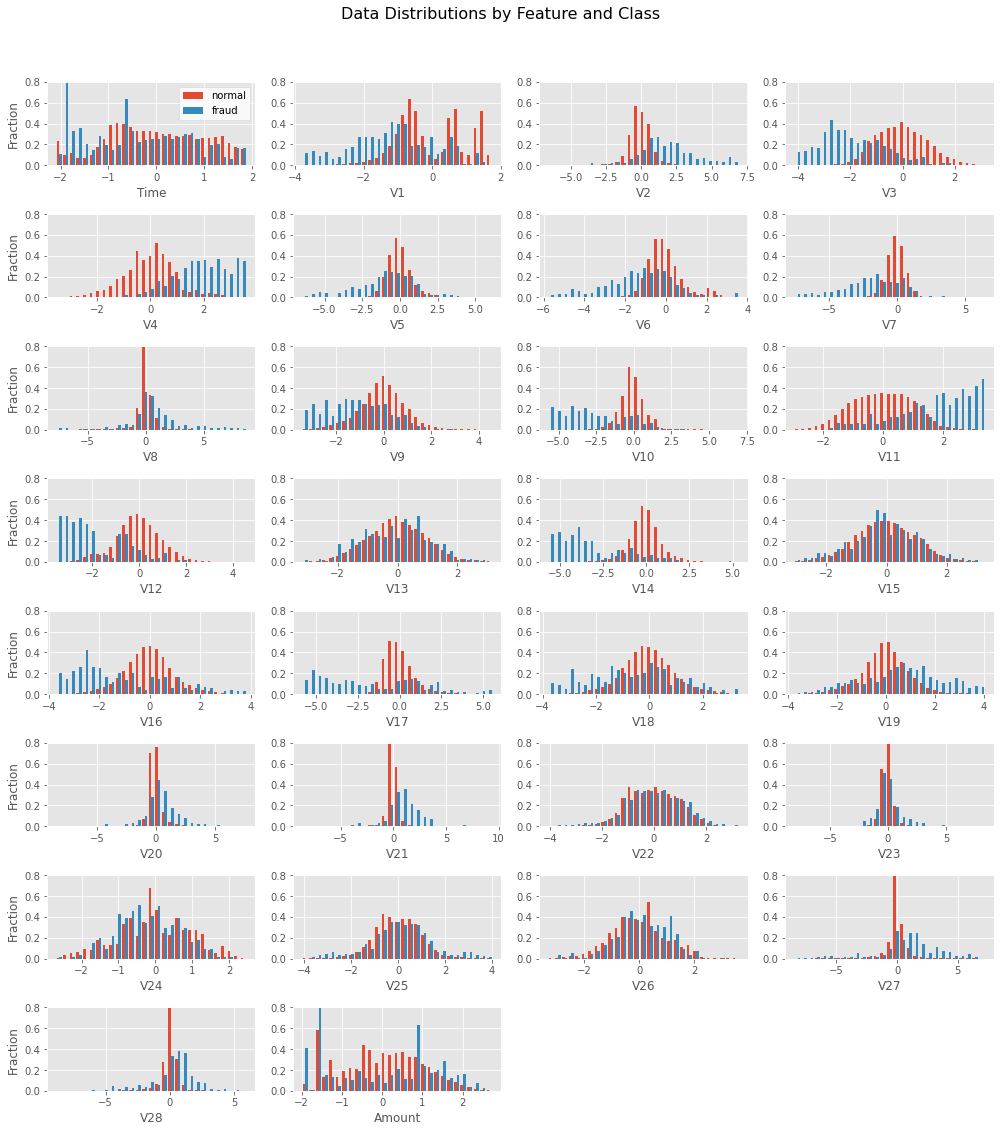

In [275]:
# Plot the data by each feature

axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

_ = f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data.Class == 0, col ], data.loc[ data.Class == 1, col ] ], label=['normal','fraud'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30 ),
                          density=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.savefig('../reports/figures/Engineered_Data_Distributions.png')
plt.show()

In [276]:
# Save engineered dataset for use in analysis
# Save as pickle for faster reload

pickle.dump(data, open(processed_data + 'credicard.engineered.pkl','wb'))

## Hospital Readmissions

In [247]:
data = readmissions.copy()
data_cols = list(data.columns[ data.columns != 'readmitted'])
label_cols = ['readmitted']

print('Dataset columns: {}'.format(data_cols))
print('# of data columns: ',len(data_cols))
data.head()

Dataset columns: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'race_Caucasian', 'race_AfricanAmerican', 'gender_Female', 'age_[70-80)', 'age_[60-70)', 'age_[50-60)', 'age_[80-90)', 'age_[40-50)', 'payer_code_?', 'payer_code_MC', 'payer_code_HM', 'payer_code_SP', 'payer_code_BC', 'medical_specialty_?', 'medical_specialty_InternalMedicine', 'medical_specialty_Emergency/Trauma', 'medical_specialty_Family/GeneralPractice', 'medical_specialty_Cardiology', 'diag_1_428', 'diag_1_414', 'diag_1_786', 'diag_2_276', 'diag_2_428', 'diag_2_250', 'diag_2_427', 'diag_3_250', 'diag_3_401', 'diag_3_276', 'diag_3_428', 'max_glu_serum_None', 'A1Cresult_None', 'metformin_No', 'repaglinide_No', 'nateglinide_No', 'chlorpropamide_No', 'glimepiride_No', 'acetohexamide_No', 'glipizide_No', 'glyburide_No', 'tolbutamide_No', 'pioglitazone_No', 'rosiglitazone_No', 'acarbose_No', 'miglitol_No', 'trog

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Caucasian,race_AfricanAmerican,gender_Female,age_[70-80),age_[60-70),age_[50-60),age_[80-90),age_[40-50),payer_code_?,payer_code_MC,payer_code_HM,payer_code_SP,payer_code_BC,medical_specialty_?,medical_specialty_InternalMedicine,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,...,repaglinide_No,nateglinide_No,chlorpropamide_No,glimepiride_No,acetohexamide_No,glipizide_No,glyburide_No,tolbutamide_No,pioglitazone_No,rosiglitazone_No,acarbose_No,miglitol_No,troglitazone_No,tolazamide_No,examide_No,citoglipton_No,insulin_No,glyburide-metformin_No,glipizide-metformin_No,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-pioglitazone_No,change_No,diabetesMed_Yes,readmitted
0,14,41,0,11,0,0,0,6,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,...,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0
1,2,30,0,12,0,0,1,9,True,False,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,...,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,1
2,5,66,0,22,1,0,2,9,True,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1
3,3,63,0,8,0,0,0,8,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,...,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1
4,5,40,0,6,0,0,1,9,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,0


In [248]:
# 13590 non-readmitted(class 0)
# 11410 readmitted (class 1)

data.groupby('readmitted')['readmitted'].count()

readmitted
0    13590
1    11410
Name: readmitted, dtype: int64

In [249]:
# Total nulls in dataset (sum over rows, then over columns)

data.isnull().sum().sum()

0

In [250]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 65 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   time_in_hospital                          25000 non-null  int64
 1   num_lab_procedures                        25000 non-null  int64
 2   num_procedures                            25000 non-null  int64
 3   num_medications                           25000 non-null  int64
 4   number_outpatient                         25000 non-null  int64
 5   number_emergency                          25000 non-null  int64
 6   number_inpatient                          25000 non-null  int64
 7   number_diagnoses                          25000 non-null  int64
 8   race_Caucasian                            25000 non-null  bool 
 9   race_AfricanAmerican                      25000 non-null  bool 
 10  gender_Female                             25000 non-null  

In [251]:
# Duplicates? No

normal_duplicates = sum( data.loc[ data.readmitted==0 ].duplicated() )
fraud_duplicates = sum( data.loc[ data.readmitted==1 ].duplicated() )
total_duplicates = normal_duplicates + fraud_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Fraud duplicates', fraud_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(data) )

Normal duplicates 0
Fraud duplicates 0
Total duplicates 0
Fraction duplicated 0.0


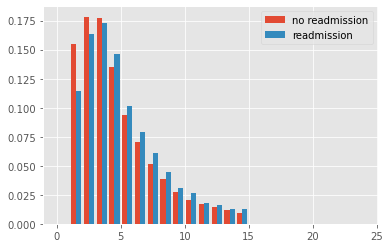

In [252]:
# Distribution of time in hospital by readmission

_ = plt.hist( [ data.loc[ data['readmitted']==0, 'time_in_hospital'], data.loc[ data['readmitted']==1, 'time_in_hospital'] ],
         density=True, label=['no readmission','readmission'], bins=np.linspace(0,24,25))
plt.legend()
plt.show()


In [253]:
# Check features that are unary or near unary -- these should be removed because they would not help at all with
# distinguishing readmissions

data = data.loc[:,data.apply(pd.Series.nunique) != 1]
print(data.shape)
data.head()

(25000, 60)


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Caucasian,race_AfricanAmerican,gender_Female,age_[70-80),age_[60-70),age_[50-60),age_[80-90),age_[40-50),payer_code_?,payer_code_MC,payer_code_HM,payer_code_SP,payer_code_BC,medical_specialty_?,medical_specialty_InternalMedicine,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,...,diag_3_276,diag_3_428,max_glu_serum_None,A1Cresult_None,metformin_No,repaglinide_No,nateglinide_No,chlorpropamide_No,glimepiride_No,glipizide_No,glyburide_No,tolbutamide_No,pioglitazone_No,rosiglitazone_No,acarbose_No,miglitol_No,troglitazone_No,tolazamide_No,insulin_No,glyburide-metformin_No,glipizide-metformin_No,glimepiride-pioglitazone_No,change_No,diabetesMed_Yes,readmitted
0,14,41,0,11,0,0,0,6,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,...,False,False,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0
1,2,30,0,12,0,0,1,9,True,False,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,...,False,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,True,1
2,5,66,0,22,1,0,2,9,True,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,...,False,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1
3,3,63,0,8,0,0,0,8,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,...,False,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,1
4,5,40,0,6,0,0,1,9,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,...,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,0


In [254]:
for col in data.columns:
    if (len(data[col].unique()) < 4):
        #print(data[col].value_counts())
        print(data[col].value_counts()/len(data)*100)

        #DROP FEATURES with values less than 1% of total

True     74.212
False    25.788
Name: race_Caucasian, dtype: float64
False    80.732
True     19.268
Name: race_AfricanAmerican, dtype: float64
True     53.748
False    46.252
Name: gender_Female, dtype: float64
False    74.868
True     25.132
Name: age_[70-80), dtype: float64
False    78.156
True     21.844
Name: age_[60-70), dtype: float64
False    82.72
True     17.28
Name: age_[50-60), dtype: float64
False    82.972
True     17.028
Name: age_[80-90), dtype: float64
False    90.288
True      9.712
Name: age_[40-50), dtype: float64
False    59.98
True     40.02
Name: payer_code_?, dtype: float64
False    68.684
True     31.316
Name: payer_code_MC, dtype: float64
False    93.896
True      6.104
Name: payer_code_HM, dtype: float64
False    95.192
True      4.808
Name: payer_code_SP, dtype: float64
False    95.428
True      4.572
Name: payer_code_BC, dtype: float64
False    50.82
True     49.18
Name: medical_specialty_?, dtype: float64
False    85.896
True     14.104
Name: medical_speci

In [255]:
data = data.drop(['repaglinide_No','nateglinide_No','glyburide_No','rosiglitazone_No','acarbose_No','miglitol_No','troglitazone_No'
                 ,'insulin_No','glyburide-metformin_No','glipizide-metformin_No'], axis=1)
print("We've been able to reduce the features to => {}".format(data.shape[1]))

We've been able to reduce the features to => 50


In [256]:
data_cols = list(data.columns[ data.columns != 'readmitted'])
categorical_features = list(data.select_dtypes(include=['bool']))
continuous_features = list(data.select_dtypes(include=['int64']))
continuous_features.remove('readmitted')

(array([[0.34520292, 0.        , 0.39789438, 0.        , 0.39543216,
         0.        , 0.3012113 , 0.        , 0.20912436, 0.        ,
         0.        , 0.15791023, 0.        , 0.11506764, 0.        ,
         0.08535688, 0.        , 0.06040641, 0.        , 0.        ,
         0.04612554, 0.        , 0.0380823 , 0.        , 0.03151639,
         0.        , 0.02609951, 0.        , 0.02133922],
        [0.25592261, 0.        , 0.36482168, 0.        , 0.38515472,
         0.        , 0.32669723, 0.        , 0.22718263, 0.        ,
         0.        , 0.17595901, 0.        , 0.13548844, 0.        ,
         0.10029664, 0.        , 0.06823299, 0.        , 0.        ,
         0.05845749, 0.        , 0.03968853, 0.        , 0.03656037,
         0.        , 0.02756691, 0.        , 0.02873997]]),
 array([ 1.        ,  1.44827586,  1.89655172,  2.34482759,  2.79310345,
         3.24137931,  3.68965517,  4.13793103,  4.5862069 ,  5.03448276,
         5.48275862,  5.93103448,  6.37931034,

Text(0.5, 0, 'time_in_hospital')

(0.0, 0.8)

Text(0, 0.5, 'Fraction')

(array([[0.0172867 , 0.00302573, 0.00651866, 0.00596246, 0.00631843,
         0.00809827, 0.00914393, 0.0088547 , 0.01114625, 0.01650802,
         0.0183101 , 0.01986746, 0.02930061, 0.01915553, 0.01746468,
         0.01566259, 0.02120234, 0.0145057 , 0.01259237, 0.01388275,
         0.00756432, 0.00565099, 0.00578448, 0.002781  , 0.00209131,
         0.00157961, 0.0006007 , 0.0006007 , 0.00062294],
        [0.01510682, 0.00265032, 0.00614874, 0.00548616, 0.00492959,
         0.00630776, 0.00795096, 0.00890507, 0.01155539, 0.01587541,
         0.01712106, 0.01894978, 0.02814639, 0.0191353 , 0.01812818,
         0.01720057, 0.02199765, 0.01486829, 0.01441773, 0.01568989,
         0.00893157, 0.0075004 , 0.00638727, 0.00325989, 0.00222627,
         0.00177571, 0.00071559, 0.00026503, 0.00045055]]),
 array([ 1.        ,  4.31034483,  7.62068966, 10.93103448, 14.24137931,
        17.55172414, 20.86206897, 24.17241379, 27.48275862, 30.79310345,
        34.10344828, 37.4137931 , 40.72413793,

Text(0.5, 0, 'num_lab_procedures')

(0.0, 0.8)

(array([[2.13890115, 0.        , 0.        , 0.        , 0.95741967,
         0.        , 0.        , 0.        , 0.        , 0.62452784,
         0.        , 0.        , 0.        , 0.        , 0.47870984,
         0.        , 0.        , 0.        , 0.        , 0.21623743,
         0.        , 0.        , 0.        , 0.        , 0.15364238,
         0.        , 0.        , 0.        , 0.26389502],
        [2.30059889, 0.        , 0.        , 0.        , 1.01283961,
         0.        , 0.        , 0.        , 0.        , 0.59474145,
         0.        , 0.        , 0.        , 0.        , 0.40835524,
         0.        , 0.        , 0.        , 0.        , 0.18342098,
         0.        , 0.        , 0.        , 0.        , 0.12877593,
         0.        , 0.        , 0.        , 0.20460123]]),
 array([0.        , 0.20689655, 0.4137931 , 0.62068966, 0.82758621,
        1.03448276, 1.24137931, 1.44827586, 1.65517241, 1.86206897,
        2.06896552, 2.27586207, 2.48275862, 2.68965517, 

Text(0.5, 0, 'num_procedures')

(0.0, 0.8)

(array([[1.00998375e-02, 2.14304795e-02, 3.65983358e-02, 4.83271793e-02,
         5.45536024e-02, 5.66532102e-02, 5.44450020e-02, 4.61189711e-02,
         4.00373486e-02, 2.96479100e-02, 2.30232854e-02, 1.78828664e-02,
         1.27786474e-02, 1.07876400e-02, 6.51602418e-03, 5.35761988e-03,
         3.69241370e-03, 3.22181195e-03, 2.13580792e-03, 1.88240698e-03,
         1.30320484e-03, 1.19460443e-03, 9.05003358e-04, 5.79202149e-04,
         5.06801880e-04, 6.51602418e-04, 3.62001343e-04, 3.98201477e-04,
         4.34401612e-04],
        [5.60413130e-03, 1.24153063e-02, 2.39684385e-02, 3.93582452e-02,
         5.22046385e-02, 5.66879435e-02, 5.73776828e-02, 5.54808999e-02,
         4.51348113e-02, 3.85391799e-02, 2.85379609e-02, 2.02179814e-02,
         1.67261765e-02, 1.18548931e-02, 8.31997955e-03, 5.04371817e-03,
         4.00910931e-03, 2.41408733e-03, 1.98300031e-03, 1.85367420e-03,
         9.05282748e-04, 8.19065344e-04, 6.46630535e-04, 1.72434809e-04,
         3.87978321e-04, 

Text(0.5, 0, 'num_medications')

(0.0, 0.8)

(array([[1.80731533e+00, 0.00000000e+00, 1.41358531e-01, 0.00000000e+00,
         5.47440266e-02, 0.00000000e+00, 3.24804392e-02, 0.00000000e+00,
         1.57065034e-02, 0.00000000e+00, 8.84443884e-03, 0.00000000e+00,
         4.87969039e-03, 0.00000000e+00, 1.67739357e-03, 0.00000000e+00,
         1.67739357e-03, 0.00000000e+00, 1.21992260e-03, 0.00000000e+00,
         6.09961299e-04, 0.00000000e+00, 4.57470974e-04, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 3.04980650e-04, 0.00000000e+00,
         1.52490325e-04],
        [1.63209522e+00, 0.00000000e+00, 2.26301208e-01, 0.00000000e+00,
         9.81547410e-02, 0.00000000e+00, 4.83502984e-02, 0.00000000e+00,
         2.81740460e-02, 0.00000000e+00, 1.54502833e-02, 0.00000000e+00,
         8.36132979e-03, 0.00000000e+00, 4.18066489e-03, 0.00000000e+00,
         1.99944843e-03, 0.00000000e+00, 1.99944843e-03, 0.00000000e+00,
         1.63591235e-03, 0.00000000e+00, 2.18121647e-03, 0.00000000e+00,
         5.45304117e-04, 

Text(0.5, 0, 'number_outpatient')

(0.0, 0.8)

Text(0, 0.5, 'Fraction')

(array([[2.67782602e+00, 0.00000000e+00, 1.64336179e-01, 0.00000000e+00,
         0.00000000e+00, 3.84162496e-02, 0.00000000e+00, 0.00000000e+00,
         1.08846041e-02, 0.00000000e+00, 0.00000000e+00, 3.41477775e-03,
         0.00000000e+00, 0.00000000e+00, 2.13423609e-03, 0.00000000e+00,
         0.00000000e+00, 1.49396526e-03, 0.00000000e+00, 0.00000000e+00,
         6.40270827e-04, 0.00000000e+00, 0.00000000e+00, 2.13423609e-04,
         0.00000000e+00, 0.00000000e+00, 6.40270827e-04, 0.00000000e+00,
         0.00000000e+00],
        [2.44344543e+00, 0.00000000e+00, 2.88752305e-01, 0.00000000e+00,
         0.00000000e+00, 9.62507683e-02, 0.00000000e+00, 0.00000000e+00,
         2.97919045e-02, 0.00000000e+00, 0.00000000e+00, 1.80788480e-02,
         0.00000000e+00, 0.00000000e+00, 7.89358153e-03, 0.00000000e+00,
         0.00000000e+00, 5.34726490e-03, 0.00000000e+00, 0.00000000e+00,
         5.09263324e-03, 0.00000000e+00, 0.00000000e+00, 2.29168496e-03,
         0.00000000e+00, 

Text(0.5, 0, 'number_emergency')

(0.0, 0.8)

(array([[2.19191258e+00, 0.00000000e+00, 4.65656045e-01, 0.00000000e+00,
         0.00000000e+00, 1.39995585e-01, 0.00000000e+00, 0.00000000e+00,
         5.97542130e-02, 0.00000000e+00, 0.00000000e+00, 2.36882773e-02,
         0.00000000e+00, 0.00000000e+00, 8.53631614e-03, 0.00000000e+00,
         0.00000000e+00, 4.26815807e-03, 0.00000000e+00, 0.00000000e+00,
         3.62793436e-03, 0.00000000e+00, 0.00000000e+00, 1.06703952e-03,
         0.00000000e+00, 0.00000000e+00, 1.28044742e-03, 0.00000000e+00,
         2.13407903e-04],
        [1.59707561e+00, 0.00000000e+00, 6.64705366e-01, 0.00000000e+00,
         0.00000000e+00, 3.14015983e-01, 0.00000000e+00, 0.00000000e+00,
         1.50513744e-01, 0.00000000e+00, 0.00000000e+00, 7.66575920e-02,
         0.00000000e+00, 0.00000000e+00, 4.02388689e-02, 0.00000000e+00,
         0.00000000e+00, 2.31755511e-02, 0.00000000e+00, 0.00000000e+00,
         1.47712304e-02, 0.00000000e+00, 0.00000000e+00, 8.40432072e-03,
         0.00000000e+00, 

Text(0.5, 0, 'number_inpatient')

(0.0, 0.8)

(array([[1.04651831e-02, 0.00000000e+00, 3.80163796e-02, 0.00000000e+00,
         0.00000000e+00, 9.95260274e-02, 0.00000000e+00, 0.00000000e+00,
         1.87518996e-01, 0.00000000e+00, 0.00000000e+00, 3.87425351e-01,
         0.00000000e+00, 0.00000000e+00, 3.06907514e-01, 0.00000000e+00,
         0.00000000e+00, 2.98150932e-01, 0.00000000e+00, 0.00000000e+00,
         2.87472173e-01, 0.00000000e+00, 0.00000000e+00, 1.28401390e+00,
         0.00000000e+00, 0.00000000e+00, 2.13575166e-04, 0.00000000e+00,
         0.00000000e+00],
        [2.54405161e-03, 0.00000000e+00, 2.00980077e-02, 0.00000000e+00,
         0.00000000e+00, 6.15660490e-02, 0.00000000e+00, 0.00000000e+00,
         1.25930555e-01, 0.00000000e+00, 0.00000000e+00, 2.42448119e-01,
         0.00000000e+00, 0.00000000e+00, 2.67634230e-01, 0.00000000e+00,
         0.00000000e+00, 3.00706901e-01, 0.00000000e+00, 0.00000000e+00,
         3.10628702e-01, 0.00000000e+00, 0.00000000e+00, 1.56713579e+00,
         0.00000000e+00, 

Text(0.5, 0, 'number_diagnoses')

(0.0, 0.8)

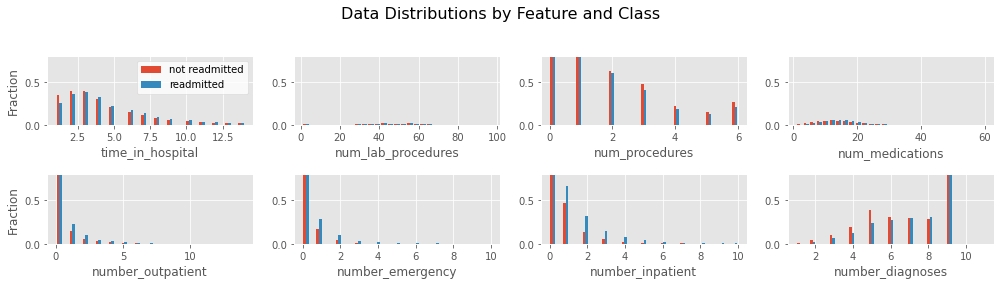

In [257]:
# Plot the data by each feature

axarr = [[]]*len(continuous_features)
columns = 4
rows = int( np.ceil( len(continuous_features) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

_ = f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(continuous_features[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data.readmitted == 0, col ], data.loc[ data.readmitted == 1, col ] ], label=['not readmitted','readmitted'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30 ),
                          density=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.savefig('../reports/figures/Original_Data_Distributions_readmissions.png')
plt.show()

In [258]:
#Encode categorical features
for column in categorical_features:
    data[column] = data[column].astype('category').cat.codes

data.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Caucasian,race_AfricanAmerican,gender_Female,age_[70-80),age_[60-70),age_[50-60),age_[80-90),age_[40-50),payer_code_?,payer_code_MC,payer_code_HM,payer_code_SP,payer_code_BC,medical_specialty_?,medical_specialty_InternalMedicine,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_Cardiology,diag_1_428,diag_1_414,diag_1_786,diag_2_276,diag_2_428,diag_2_250,diag_2_427,diag_3_250,diag_3_401,diag_3_276,diag_3_428,max_glu_serum_None,A1Cresult_None,metformin_No,chlorpropamide_No,glimepiride_No,glipizide_No,tolbutamide_No,pioglitazone_No,tolazamide_No,glimepiride-pioglitazone_No,change_No,diabetesMed_Yes,readmitted
0,14,41,0,11,0,0,0,6,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0
1,2,30,0,12,0,0,1,9,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,1,1,0,1,1
2,5,66,0,22,1,0,2,9,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1
3,3,63,0,8,0,0,0,8,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
4,5,40,0,6,0,0,1,9,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0


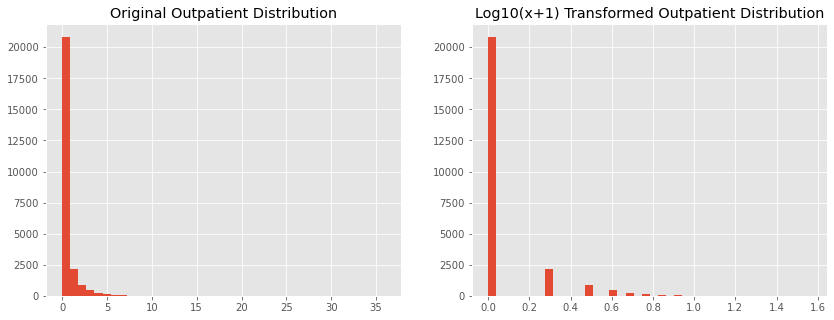

In [211]:
# log transform highly skewed continuous features
#Example of skewed feature

_ = plt.figure(figsize=(14,5))
_ = plt.subplot(1,2,1);
_ = plt.hist(data['number_outpatient'], bins=40)
_ = plt.title('Original Outpatient Distribution')

_ = plt.subplot(1,2,2)
d0 = np.log10( data['number_outpatient'].values + 1 )
_ = plt.hist( d0, bins=40 )
_ = plt.title('Log10(x+1) Transformed Outpatient Distribution')
plt.show()

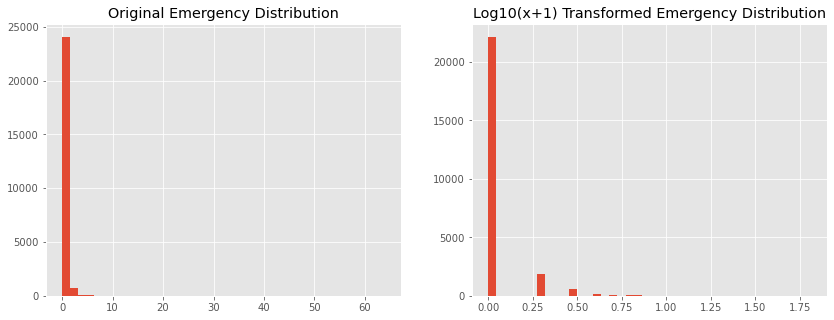

In [212]:
# log transform highly skewed continuous features
#Example of skewed feature

_ = plt.figure(figsize=(14,5))
_ = plt.subplot(1,2,1);
_ = plt.hist(data['number_emergency'], bins=40)
_ = plt.title('Original Emergency Distribution')

_ = plt.subplot(1,2,2)
d1 = np.log10( data['number_emergency'].values + 1 )
_ = plt.hist( d1, bins=40 )
_ = plt.title('Log10(x+1) Transformed Emergency Distribution')
plt.show()

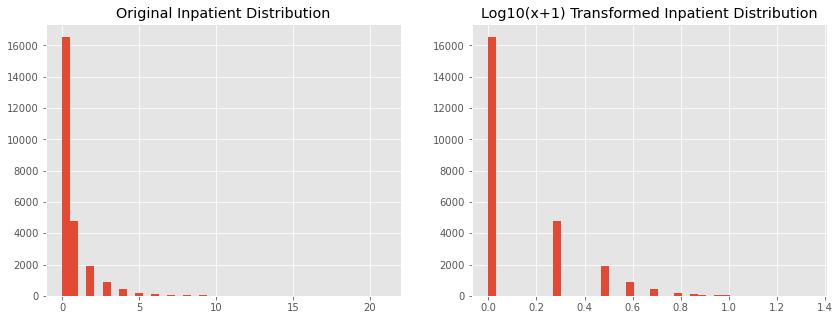

In [213]:
# log transform highly skewed continuous features
#Example of skewed feature

_ = plt.figure(figsize=(14,5))
_ = plt.subplot(1,2,1);
_ = plt.hist(data['number_inpatient'], bins=40)
_ = plt.title('Original Inpatient Distribution')

_ = plt.subplot(1,2,2)
d2 = np.log10( data['number_inpatient'].values + 1 )
_ = plt.hist( d2, bins=40 )
_ = plt.title('Log10(x+1) Transformed Inpatient Distribution')
plt.show()

In [259]:
# Center and scale all data, only using the middle 99.8%, so outliers don't pull too much.
# First generate the percentile data for each feature

percentiles =  pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.9 ] ) for i in continuous_features ]).T,
                            columns=continuous_features, index=['min','max'] )

percentile_means = \
    [ [ np.mean( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in continuous_features ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=continuous_features, index=['mean']) )

percentile_stds = \
    [ [ np.std( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in continuous_features ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=continuous_features, index=['stdev']) )

percentiles

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,14.000000,97.000000,6.000000,60.000000,14.000000,10.000000,10.000000,11.001000
mean,4.814462,44.299130,2.123033,15.974904,2.083293,1.617533,1.852798,7.428199
stdev,2.697211,18.395464,1.208055,7.918765,1.698997,1.225419,1.354772,1.904913


In [260]:
# Center and scale the data using the percentile data we just generated

data[continuous_features] = ( data[continuous_features] - percentiles.loc[ 'mean', continuous_features ] ) / percentiles.loc[ 'stdev', continuous_features ]


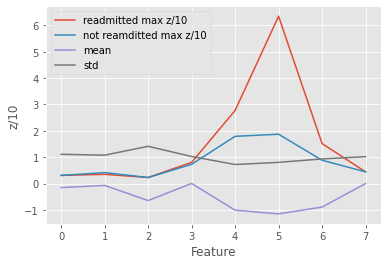

In [261]:
# There are outliers, 50-100 stdevs away from mean in several columns

plot_cols = continuous_features
# plt.plot( np.log10( data[ plot_cols ].abs().max().values ) )
# plt.plot( data[ plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='max z/10' )
plt.plot( data.loc[ data.readmitted==1, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='readmitted max z/10' )
plt.plot( data.loc[ data.readmitted==0, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='not reamditted max z/10' )
plt.plot( data[ plot_cols ].mean().values, label='mean' )
# plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
plt.plot( data[ plot_cols ].std().values, label='std' )
plt.xlabel('Feature')
plt.ylabel('z/10')
plt.legend() ; 

In [262]:
#Transform data to Gaussian

data[data_cols] = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(data[data_cols])

data.head()

/Users/jrudd/opt/anaconda3/envs/gans_env/lib/python3.8/site-packages/numpy/core/_methods.py:195: RuntimeWarning:

overflow encountered in multiply

/Users/jrudd/opt/anaconda3/envs/gans_env/lib/python3.8/site-packages/numpy/core/_methods.py:199: RuntimeWarning:

overflow encountered in reduce



,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Caucasian,race_AfricanAmerican,gender_Female,age_[70-80),age_[60-70),age_[50-60),age_[80-90),age_[40-50),payer_code_?,payer_code_MC,payer_code_HM,payer_code_SP,payer_code_BC,medical_specialty_?,medical_specialty_InternalMedicine,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_Cardiology,diag_1_428,diag_1_414,diag_1_786,diag_2_276,diag_2_428,diag_2_250,diag_2_427,diag_3_250,diag_3_401,diag_3_276,diag_3_428,max_glu_serum_None,A1Cresult_None,metformin_No,chlorpropamide_No,glimepiride_No,glipizide_No,tolbutamide_No,pioglitazone_No,tolazamide_No,glimepiride-pioglitazone_No,change_No,diabetesMed_Yes,readmitted
0,2.111678,-0.154080,-0.964258,-0.577016,-0.446349,-0.359197,-0.695041,-0.912755,0.589484,-0.488535,-1.077993,-0.579383,-0.52867,2.187930,-0.453019,-0.327974,-0.816837,-0.675236,-0.254967,4.449570,-0.218885,1.016537,-0.405214,-0.286222,-0.285486,-0.230765,-0.26349,-0.258155,-0.205291,-0.27139,-0.26849,-0.254165,-0.227866,-0.358561,3.345023,-0.228448,-0.21606,0.241063,0.453403,0.491171,0.026842,0.234111,-2.677673,0.015494,0.278209,0.020981,0.006325,0.918138,0.550546,0
1,-0.894297,-0.685450,-0.964258,-0.404558,-0.446349,-0.359197,1.014742,0.867835,0.589484,-0.488535,0.927650,-0.579383,-0.52867,2.187930,-0.453019,-0.327974,-0.816837,-0.675236,-0.254967,4.449570,-0.218885,1.016537,-0.405214,-0.286222,-0.285486,-0.230765,-0.26349,-0.258155,-0.205291,-0.27139,-0.26849,-0.254165,-0.227866,-0.358561,-0.298952,-0.228448,-0.21606,0.241063,0.453403,0.491171,0.026842,0.234111,0.373459,0.015494,-3.594415,0.020981,0.006325,-1.089160,0.550546,1
2,0.510231,1.199084,-0.964258,0.876331,2.072255,-0.359197,1.686747,0.867835,0.589484,-0.488535,0.927650,-0.579383,-0.52867,-0.457053,2.207415,-0.327974,-0.816837,1.480964,-0.254967,-0.224741,-0.218885,1.016537,-0.405214,-0.286222,-0.285486,-0.230765,-0.26349,-0.258155,-0.205291,-0.27139,-0.26849,-0.254165,-0.227866,-0.358561,-0.298952,-0.228448,-0.21606,0.241063,-2.205542,-2.035950,0.026842,0.234111,0.373459,0.015494,0.278209,0.020981,0.006325,0.918138,0.550546,1
3,-0.337258,1.027579,-0.964258,-1.140125,-0.446349,-0.359197,-0.695041,0.089744,0.589484,-0.488535,0.927650,-0.579383,-0.52867,2.187930,-0.453019,-0.327974,1.224235,-0.675236,-0.254967,-0.224741,-0.218885,1.016537,-0.405214,-0.286222,-0.285486,-0.230765,-0.26349,3.873644,-0.205291,-0.27139,-0.26849,-0.254165,-0.227866,-0.358561,-0.298952,-0.228448,-0.21606,0.241063,0.453403,0.491171,0.026842,0.234111,0.373459,0.015494,0.278209,0.020981,0.006325,0.918138,0.550546,1
4,0.510231,-0.203821,-0.964258,-1.551454,-0.446349,-0.359197,1.014742,0.867835,0.589484,-0.488535,0.927650,-0.579383,-0.52867,-0.457053,2.207415,-0.327974,1.224235,-0.675236,-0.254967,-0.224741,-0.218885,-0.983732,-0.405214,-0.286222,3.502804,-0.230765,-0.26349,-0.258155,-0.205291,-0.27139,-0.26849,-0.254165,-0.227866,-0.358561,3.345023,-0.228448,-0.21606,0.241063,0.453403,0.491171,0.026842,0.234111,0.373459,0.015494,0.278209,0.020981,0.006325,0.918138,-1.816377,0


In [263]:
# Save engineered dataset for use in analysis
# Save as pickle for faster reload

pickle.dump(data, open(processed_data + 'readmissions.engineered.pkl','wb'))


# Model Testing

## Credit data

In [291]:
# Load engineered dataset from EDA section

data = pickle.load(open(processed_data + 'credicard.engineered.pkl','rb'))

# data columns will be all other columns except class
data_cols = list(data.columns[ data.columns != 'Class' ])
label_cols = ['Class']

print(data_cols)
print('# of data columns: ',len(data_cols))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
# of data columns:  30


In [294]:
# define the columns we want to test on, in case we want to use less than the full set

test_cols = data.columns

print(len(test_cols))
print(test_cols)
print(data.Class.unique())
data.head()

31
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
[0 1]


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-2.097892,-0.918361,-0.126941,2.179072,0.985929,-0.256348,0.453311,0.193567,0.019899,0.380248,0.127280,-0.513029,-0.773716,-0.997406,-0.404862,1.711526,-0.600737,0.215343,0.010324,0.503249,0.324326,-0.004980,0.366815,-0.190321,0.008864,0.209150,-0.320634,0.319677,-0.051441,1.116232,0
1,-2.097892,0.627278,0.097411,-0.030922,0.387996,0.031793,0.038355,-0.063818,0.006326,-0.184730,-0.114989,1.523893,1.297063,0.498809,-0.233321,0.674971,0.491301,-0.174764,-0.238217,-0.169665,-0.092147,-0.297283,-0.883694,0.152007,-0.639250,0.286009,0.356852,-0.041941,0.058518,-1.128782,0
2,-2.097861,-0.917772,-0.876575,1.379633,0.341674,-0.374776,1.327090,0.639733,0.171795,-1.453454,0.234507,0.640717,-0.106076,0.724944,-0.256407,2.871130,-2.809860,1.379931,-0.164889,-2.836166,0.681052,0.359178,1.069681,1.507168,-1.129176,-0.653908,-0.205645,-0.157419,-0.171327,1.629849,0
3,-2.097861,-0.751287,-0.198599,1.399416,-0.580509,-0.019312,0.984311,0.191959,0.308552,-1.319307,-0.008705,-0.179208,0.025795,0.517338,-0.381402,-0.720131,-1.192490,-0.825670,2.432502,-1.528564,-0.272131,-0.130886,-0.013017,-0.317606,-1.748833,1.279747,-0.397429,0.138793,0.200887,1.008889,0
4,-2.097829,-0.834752,0.531035,1.158863,0.357472,-0.305871,0.179725,0.479228,-0.331302,0.769637,0.718426,-0.798731,0.495542,1.343519,-1.166584,0.137789,-0.580778,-0.317908,-0.066081,0.986295,0.529106,0.007357,1.107968,-0.233433,0.140403,-0.431047,1.048430,0.541582,0.661431,0.688624,0


In [295]:
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

In [289]:
# Set up the test and train sets

np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
train_fraction = 0.7
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

classes 0, 1:  284315 492
train, test:  199364 85443


In [306]:
# Run the xgboost algorithm, maximize recall on the test set

results_dict = {}

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df['Class'].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall( y_pred, dtest) )
print( precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest) )
# print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
SimpleMetrics( np.round(y_pred), y_true)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

# GAN Data Synthesizing


In [63]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam

class GAN():
    
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))
        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)
    
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
    
            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
    
            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                #Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = '../models' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                #Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator(z)
                print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator
    
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        input= Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dense(data_dim)(x)
        return Model(inputs=input, outputs=x)

class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

## Credit data

In [64]:
#Define the GAN and training parameters
train_data = credit_processed
noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
epochs = 200+1
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
models_dir = '../models'

train_sample = train_data.copy().reset_index(drop=True)
train_sample = pd.get_dummies(train_sample, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train_sample.columns if 'Class' in i ]
data_cols = [ i for i in train_sample.columns if i not in label_cols ]
train_sample[ data_cols ] = train_sample[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train_sample[ data_cols ]

gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, train_sample.shape[1], dim]
train_args = ['', epochs, log_step]

In [65]:
#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
model = VanilllaGAN
synthesizer = model(gan_args)
synthesizer.train(train_sample, train_args)

0 [D loss: 0.722783, acc.: 42.19%] [G loss: 0.660949]
generated_data
1 [D loss: 0.707327, acc.: 50.00%] [G loss: 0.692486]
2 [D loss: 0.690700, acc.: 59.77%] [G loss: 0.731108]
3 [D loss: 0.679712, acc.: 79.30%] [G loss: 0.759216]
4 [D loss: 0.680321, acc.: 75.39%] [G loss: 0.762747]
5 [D loss: 0.691376, acc.: 58.98%] [G loss: 0.751459]
6 [D loss: 0.702637, acc.: 48.83%] [G loss: 0.738473]
7 [D loss: 0.711071, acc.: 41.41%] [G loss: 0.735447]
8 [D loss: 0.709876, acc.: 37.11%] [G loss: 0.739019]
9 [D loss: 0.706704, acc.: 42.19%] [G loss: 0.775413]
10 [D loss: 0.686106, acc.: 55.08%] [G loss: 0.813722]
11 [D loss: 0.667987, acc.: 67.58%] [G loss: 0.853355]
12 [D loss: 0.658877, acc.: 72.27%] [G loss: 0.884241]
13 [D loss: 0.653484, acc.: 67.58%] [G loss: 0.889105]
14 [D loss: 0.647472, acc.: 66.41%] [G loss: 0.889278]
15 [D loss: 0.648138, acc.: 64.45%] [G loss: 0.892895]
16 [D loss: 0.648285, acc.: 63.67%] [G loss: 0.892259]
17 [D loss: 0.647820, acc.: 62.89%] [G loss: 0.873692]
18 [D

148 [D loss: 0.602872, acc.: 84.77%] [G loss: 0.956921]
149 [D loss: 0.626976, acc.: 76.95%] [G loss: 0.880357]
150 [D loss: 0.661945, acc.: 62.89%] [G loss: 0.788125]
151 [D loss: 0.692632, acc.: 54.69%] [G loss: 0.755443]
152 [D loss: 0.702905, acc.: 48.83%] [G loss: 0.718254]
153 [D loss: 0.696723, acc.: 49.22%] [G loss: 0.719269]
154 [D loss: 0.686611, acc.: 53.52%] [G loss: 0.736606]
155 [D loss: 0.674745, acc.: 55.08%] [G loss: 0.774919]
156 [D loss: 0.649860, acc.: 68.75%] [G loss: 0.821329]
157 [D loss: 0.637798, acc.: 75.00%] [G loss: 0.834874]
158 [D loss: 0.634523, acc.: 77.73%] [G loss: 0.857834]
159 [D loss: 0.633339, acc.: 79.69%] [G loss: 0.852964]
160 [D loss: 0.635470, acc.: 74.22%] [G loss: 0.844177]
161 [D loss: 0.650946, acc.: 68.36%] [G loss: 0.818777]
162 [D loss: 0.673421, acc.: 58.98%] [G loss: 0.739530]
163 [D loss: 0.693789, acc.: 53.91%] [G loss: 0.703002]
164 [D loss: 0.708838, acc.: 46.09%] [G loss: 0.675272]
165 [D loss: 0.727895, acc.: 44.92%] [G loss: 0.

In [66]:
#Generator discription
synthesizer.generator.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(128, 32)]               0         
_________________________________________________________________
dense_16 (Dense)             (128, 128)                4224      
_________________________________________________________________
dense_17 (Dense)             (128, 256)                33024     
_________________________________________________________________
dense_18 (Dense)             (128, 512)                131584    
_________________________________________________________________
dense_19 (Dense)             (128, 30)                 15390     
Total params: 184,222
Trainable params: 184,222
Non-trainable params: 0
_________________________________________________________________


In [67]:
#Discriminator description
synthesizer.discriminator.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(128, 30)]               0         
_________________________________________________________________
dense_20 (Dense)             (128, 512)                15872     
_________________________________________________________________
dropout_4 (Dropout)          (128, 512)                0         
_________________________________________________________________
dense_21 (Dense)             (128, 256)                131328    
_________________________________________________________________
dropout_5 (Dropout)          (128, 256)                0         
_________________________________________________________________
dense_22 (Dense)             (128, 128)                32896     
_________________________________________________________________
dense_23 (Dense)             (128, 1)                

In [68]:
#You can easily save the trained generator and loaded it aftwerwards
synthesizer.save('../models/gan')

In [69]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

# Results
Show graphs and stats here

Text(0.5, 1.0, 'Actual Fraud Data')

Text(0, 0.5, 'V10')

Text(0.5, 0, 'V17')

OSError: Unable to open file (unable to open file: name = '../models_generator_model_weights_step_0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

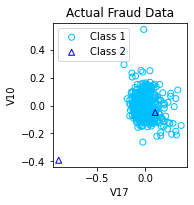

In [76]:
# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=train_sample, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols+label_cols)
labels = credit_processed['Class']

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V17', 'V10'

base_dir = '../models'

#Actual fraud data visualization
model_steps = [ 0, 200, 300]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols+['label'])
            gen_samples.to_csv(processed_data+'Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')


In [70]:
g_z=pw.inverse_transform(g_z)
gen_samples = pd.DataFrame(g_z, columns=data_cols)
gen_samples.to_csv('Generated_sample.csv')

NameError: name 'pw' is not defined

# Conclusions and Next Steps
Summarize findings here